In [3]:
import xarray as xr
import datetime as dt
import cartopy.crs as ccrs
from hurricanes.plotting import map_add_ticks, map_add_features, map_add_ticks
import numpy as np
import matplotlib.pyplot as plt
from hurricanes.regions import region_config
import cmocean

In [10]:
fname = 'rtofs_glo_3dz_f006_6hrly_hvr_US_east.nc'
dir1 = '/Users/mikesmith/Documents/rtofs_ftpprd/'
datetime = dt.datetime(2022, 8, 2, 6, 0, 0)
date_str = datetime.strftime("%Y-%m-%dT%H%M%SZ")
dir_str = datetime.strftime("rtofs.%Y%m%d")

# region = 'gom'
# vmin_salt=36
# vmax_salt=37.1
# stride_salt = .1
# vmin_deep=20
# vmax_deep=220
# stride_deep = 20
# figsize = (20,15)

region = 'caribbean'
vmin_salt=36
vmax_salt=37.5
stride_salt = .1
vmin_deep=20
vmax_deep=220
stride_deep = 20
figsize = (16,10)

In [11]:
para = xr.open_dataset(f'{dir1}/para/{dir_str}/{fname}')
prod = xr.open_dataset(f'{dir1}/prod/{dir_str}/{fname}')
v22 = xr.open_dataset(f'{dir1}/v2.2/{dir_str}/{fname}')
v23 = xr.open_dataset(f'{dir1}/v2.3/{dir_str}/{fname}')

# para.equals(prod), para.equals(v22), para.equals(v23), prod.equals(v22)
prod.equals(v23), prod.equals(v23)

(True, True)

In [4]:
# Save rtofs lon and lat as variables to speed up indexing calculation
grid_lons = prod.Longitude.values[0,:]
grid_lats = prod.Latitude.values[:,0]
grid_x = prod.X.values
grid_y = prod.Y.values

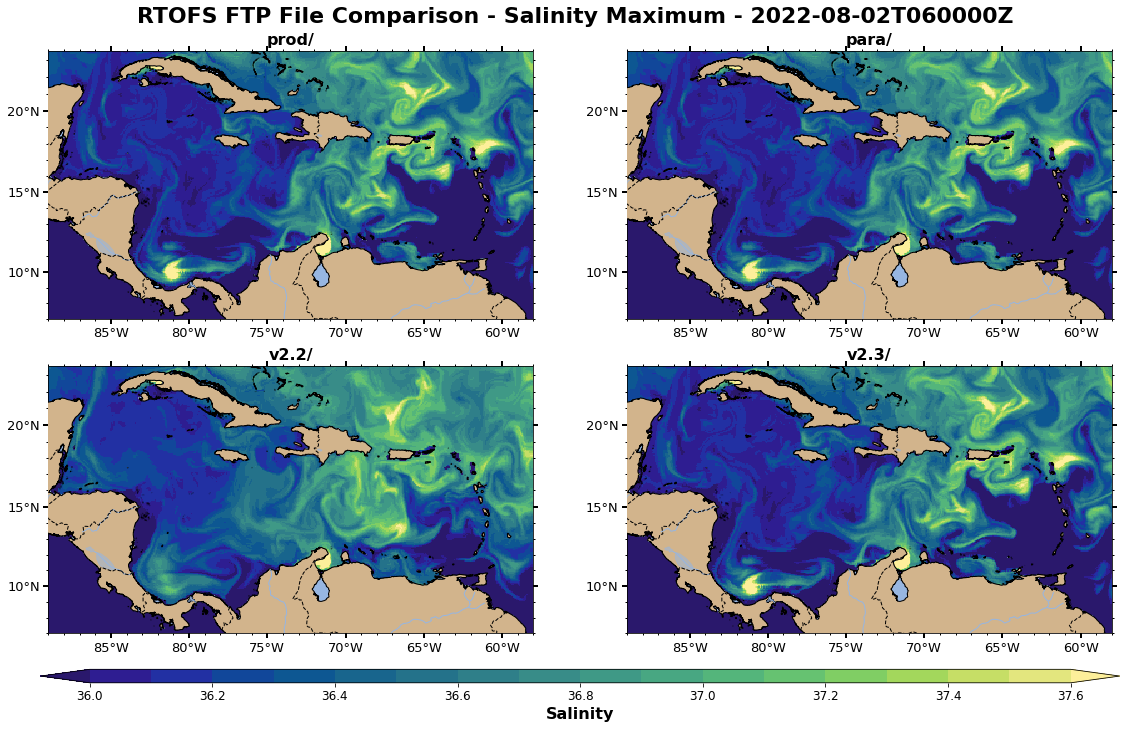

In [11]:
region_conf = region_config(region)

extent = region_conf['extent']
extended = np.add(extent, [-1, 1, -1, 1]).tolist()

# Find x, y indexes of the area we want to subset
lons_ind = np.interp(extended[:2], grid_lons, grid_x)
lats_ind = np.interp(extended[2:], grid_lats, grid_y)

# Use np.floor on the 1st index and np.ceil on the 2nd index of each slice 
# in order to widen the area of the extent slightly.
extent_ind = [
    np.floor(lons_ind[0]).astype(int),
    np.ceil(lons_ind[1]).astype(int),
    np.floor(lats_ind[0]).astype(int),
    np.ceil(lats_ind[1]).astype(int)
    ]

# Use .isel selector on x/y since we know indexes that we want to slice
prodt = prod.isel(X=slice(extent_ind[0], extent_ind[1]), Y=slice(extent_ind[2], extent_ind[3]))
parat = para.isel(X=slice(extent_ind[0], extent_ind[1]), Y=slice(extent_ind[2], extent_ind[3]))
v22t = v22.isel(X=slice(extent_ind[0], extent_ind[1]), Y=slice(extent_ind[2], extent_ind[3]))
v23t = v23.isel(X=slice(extent_ind[0], extent_ind[1]), Y=slice(extent_ind[2], extent_ind[3]))

# Calculate salinity max
prod_smax = prodt['salinity'].max("Depth")
para_smax = parat['salinity'].max("Depth")
v22_smax = v22t['salinity'].max("Depth")
v23_smax = v23t['salinity'].max("Depth")

# Get the depth that the maximum salinity occurs at.
prod_smax_depth = prodt['salinity'].idxmax("Depth")
para_smax_depth = parat['salinity'].idxmax("Depth")
v22_smax_depth = v22t['salinity'].idxmax('Depth')
v23_smax_depth = v23t['salinity'].idxmax('Depth')

fig, ax = plt.subplots(2, 2,
                       figsize=figsize, #12,9
                       constrained_layout=True,
                       subplot_kw=dict(projection=ccrs.Mercator())
                      )


levels= np.arange(vmin_salt, vmax_salt + stride_salt, stride_salt)
cmap = cmocean.cm.haline
cbar_label = "Salinity"

h1 = prod_smax.plot(x='Longitude', y='Latitude', vmin=vmin_salt, vmax=vmax_salt, levels=levels, cmap=cmap, ax=ax[0,0], add_colorbar=False, transform=ccrs.PlateCarree())
map_add_features(ax=ax[0,0], extent=extent)
ax[0,0].set_title('prod/', fontsize=16, fontweight="bold")
ax[0,0].set_xlabel(None)
ax[0,0].set_ylabel(None)


para_smax.plot(x='Longitude', y='Latitude', vmin=vmin_salt, vmax=vmax_salt, levels=levels, cmap=cmap, ax=ax[0,1], add_colorbar=False, transform=ccrs.PlateCarree())
map_add_features(ax=ax[0,1], extent=extent)
ax[0,1].set_title('para/', fontsize=16, fontweight="bold")
ax[0,1].set_xlabel(None)
ax[0,1].set_ylabel(None)

v22_smax.plot(x='Longitude', y='Latitude', vmin=vmin_salt, vmax=vmax_salt, levels=levels, cmap=cmap, ax=ax[1,0], add_colorbar=False, transform=ccrs.PlateCarree())
map_add_features(ax=ax[1,0], extent=extent)
ax[1,0].set_title('v2.2/', fontsize=16, fontweight="bold")
ax[1,0].set_xlabel(None)
ax[1,0].set_ylabel(None)

v23_smax.plot(x='Longitude', y='Latitude', vmin=vmin_salt, vmax=vmax_salt, levels=levels, cmap=cmap, ax=ax[1,1], add_colorbar=False, transform=ccrs.PlateCarree())
map_add_features(ax=ax[1,1], extent=extent)
ax[1,1].set_title('v2.3/', fontsize=16, fontweight="bold")
ax[1,1].set_ylabel(None)
ax[1,1].set_xlabel(None)


cb = fig.colorbar(h1, ax=ax[1,:2], orientation="horizontal", shrink=.95, aspect=80)#, shrink=0.7, aspect=20*0.7)
cb.ax.tick_params(labelsize=12)
cb.set_label(cbar_label, fontsize=16, fontweight="bold")

# Add ticks
map_add_ticks(ax[0,0], extent)#, label_left=True)
map_add_ticks(ax[0,1], extent)#, label_left=False)
map_add_ticks(ax[1,0], extent)#, label_left=False)
map_add_ticks(ax[1,1], extent)#, label_left=True)

# Label the subplots
txt = plt.suptitle(f"RTOFS FTP File Comparison - Salinity Maximum - {date_str}", fontsize=22, fontweight="bold")
plt.savefig(f'/Users/mikesmith/Documents/plots/rtofs_ftp_comparison_salinity_max/{date_str}-{region}-salinity_max-rtofs_ftp_comparison', dpi=150, bbox_inches='tight', pad_inches=0.1, facecolor='w', )

# fig, ax = plt.subplots(2, 2,
#                        figsize=figsize, #12,9
#                        constrained_layout=True,
#                        subplot_kw=dict(projection=ccrs.Mercator())
#                       )


# levels= np.arange(vmin_deep, vmax_deep + stride_deep, stride_deep)
# cmap = cmocean.cm.deep
# cbar_label = "Depth (m)"

# h1 = prod_smax_depth.plot(x='Longitude', y='Latitude', vmin=vmin, vmax=vmax, levels=levels, cmap=cmap, ax=ax[0,0], add_colorbar=False, transform=ccrs.PlateCarree())
# map_add_features(ax=ax[0,0], extent=extent)
# ax[0,0].set_title('prod/', fontsize=16, fontweight="bold")
# ax[0,0].set_xlabel(None)
# ax[0,0].set_ylabel(None)

# para_smax_depth.plot(x='Longitude', y='Latitude', vmin=vmin, vmax=vmax, levels=levels, cmap=cmap, ax=ax[0,1], add_colorbar=False, transform=ccrs.PlateCarree())
# map_add_features(ax=ax[0,1], extent=extent)
# ax[0,1].set_title('para/', fontsize=16, fontweight="bold")
# ax[0,1].set_xlabel(None)
# ax[0,1].set_ylabel(None)

# v22_smax_depth.plot(x='Longitude', y='Latitude', vmin=vmin, vmax=vmax, levels=levels, cmap=cmap, ax=ax[1,0], add_colorbar=False, transform=ccrs.PlateCarree())
# map_add_features(ax=ax[1,0], extent=extent)
# ax[1,0].set_title('v2.2/', fontsize=16, fontweight="bold")
# ax[1,0].set_xlabel(None)
# ax[1,0].set_ylabel(None)

# v23_smax_depth.plot(x='Longitude', y='Latitude', vmin=vmin, vmax=vmax, levels=levels, cmap=cmap, ax=ax[1,1], add_colorbar=False, transform=ccrs.PlateCarree())
# map_add_features(ax=ax[1,1], extent=extent)
# ax[1,1].set_title('v2.3/', fontsize=16, fontweight="bold")
# ax[1,1].set_ylabel(None)
# ax[1,1].set_xlabel(None)

# cb = fig.colorbar(h1, ax=ax[1,:2], orientation="horizontal", shrink=.95, aspect=80)#, shrink=0.7, aspect=20*0.7)
# cb.ax.tick_params(labelsize=12)
# cb.set_label(cbar_label, fontsize=16, fontweight="bold")

# # Add ticks
# map_add_ticks(ax[0,0], extent)#, label_left=True)
# map_add_ticks(ax[0,1], extent)#, label_left=False)
# map_add_ticks(ax[1,0], extent)#, label_left=False)
# map_add_ticks(ax[1,1], extent)#, label_left=True)

# # Label the subplots
# txt = plt.suptitle(f"RTOFS FTP File Comparison - Salinity Maximum Depth - {date_str}", fontsize=22, fontweight="bold")
# plt.savefig(f'/Users/mikesmith/Documents/plots/rtofs_ftp_comparison_salinity_max/{date_str}-{region}-salinity_max_depth-rtofs_ftp_comparison', dpi=150, bbox_inches='tight', pad_inches=0.1, facecolor='w', )